# Differentiable Histograms

One of the most common data structures in HEP is the **histogram**. It is a very powerful data reduction and density estimation technique, and ubiquitous in the field.

A histogram can be thought of as a set of intervals on a 1D domain (bins), and a set of counts for each interval (yields).

We want to take the gradient of the yields with respect to the parameters that control the data (φ). But this is ill-defined -- histograms are discrete!

To illustrate this further: gradients are the language of small changes, so how do the yields change when we wiggle φ?

- events migrate between bins (discontinuous) 
- ...or stay in the same bin (zero gradient) 

So what do we do? That's the subject of this notebook :)

Check out this preprint https://arxiv.org/abs/2203.05570 for more information (section 3.2), which describes binned Kernel Density Estimates (bKDEs)

In [6]:
import relaxed
import numpy as np
import matplotlib.pyplot as plt

# matplotlib settings

plt.rc("figure", figsize=(6, 2), dpi=150, facecolor="w")

The trick is that instead of using a "hard" histogram function like `np.histogram` (using the jax version `jnp.histogram` doesn't make it differentiable by default, but for fun you can try what happens if you use that) you would use a "relaxed" version from the `relaxed` library.


As a user you will need to specify the degree of relaxation, here given by the "bandwidth" of the kernel density estimate. Try playing with the bandwidth parameter to see the effect it has on the shape -- higher = more bias, more stable gradients, and lower = more histogram-like, less stable gradients.

In [32]:
inputs = np.random.normal(1, 1, size=1000)
bins = np.linspace(-10, 10, 51)
ctrs = bins[:-1] + np.diff(bins) / 2
from scipy.stats import gaussian_kde

grid = np.linspace(-10, 10, 1000)


def hist_plot(bandwidth):
    kernel = gaussian_kde(inputs, bw_method=bandwidth)
    kde = kernel(grid)

    counts_soft_p1 = relaxed.hist(inputs, bandwidth=bandwidth, bins=bins, density=True)
    counts_hard, _ = np.histogram(inputs, bins=bins, density=True)
    plt.step(ctrs, counts_hard, label="histogram", where="mid", linestyle="dotted")
    plt.step(ctrs, counts_soft_p1, label="bKDE", where="mid", alpha=0.6)
    plt.plot(grid, kde, alpha=0.4, label="KDE", color="C1", linestyle="dashed")
    plt.legend()
    plt.xlim(-5, 5)


import ipywidgets as widgets

slider = widgets.FloatSlider(
    value=1,
    min=0.001,
    max=5.0,
    step=0.001,
    description="Bandwidth:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".3f",
)
widgets.interactive(hist_plot, bandwidth=slider)

interactive(children=(FloatSlider(value=1.0, description='Bandwidth:', max=5.0, min=0.001, readout_format='.3f…

# Optimizing through histogramming


The main advantage of "soft" histograms through `relaxed` is that you can optimise by taking gradients across the histogramming operation, i.e. histograms can be part of a loss function. We will demonstrate this by doing a "gradient-based" shift of the histogram.

If you have many events $x_i$, we ask what is the value $\Delta$ such that the peak of the histogram of  $x_i + \Delta$ is at some desired value (e.g. t=3.0). Our data was generated with a mean of 1, so we're looking for an optimum of $\Delta = 2$. Not really a useful problem, but it's illustrative enough!

For this we will set up a mean-squared error loss term 

$$L(\Delta) = (\mathrm{mean_i}(\mathrm{histogram}(x_i+\Delta)) - t)^2$$

and we will the minimize $L$ by computing gradients $\partial L \over \partial \Delta$, allowing us to perform gradient descent.


In [13]:
def shift_histo(factor, inputs):
    shifted_inputs = factor + inputs
    soft_counts = relaxed.hist(shifted_inputs, bandwidth=0.5, bins=bins)
    binned_mean = np.sum(ctrs * soft_counts / len(shifted_inputs))
    return binned_mean


def loss(param, target, inputs):
    binned_mean = shift_histo(param, inputs)
    loss = (binned_mean - target) ** 2
    return loss

delta: 0.04, loss: 3.98
delta: 0.239, loss: 3.23
delta: 0.436, loss: 2.56
delta: 0.628, loss: 1.98
delta: 0.812, loss: 1.49
delta: 0.987, loss: 1.09
delta: 1.15, loss: 0.77
delta: 1.3, loss: 0.525
delta: 1.43, loss: 0.344
delta: 1.55, loss: 0.215
delta: 1.66, loss: 0.128
delta: 1.75, loss: 0.071
delta: 1.82, loss: 0.0366
delta: 1.88, loss: 0.017
delta: 1.92, loss: 0.00688
delta: 1.95, loss: 0.00222
delta: 1.98, loss: 0.00045
delta: 1.99, loss: 1.29e-05
delta: 2, loss: 5.55e-05
delta: 2.01, loss: 0.000181


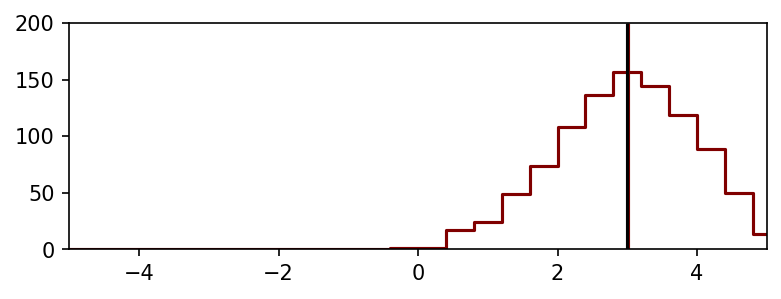

In [19]:
import jax
import optax
import celluloid

opt = optax.adam(4e-2)
params = 0.0
state = opt.init(params)
target = 3.0

fig, ax = plt.subplots()

cam = celluloid.Camera(fig)

for i in range(100):
    lvalue, g = jax.value_and_grad(loss)(params, target, inputs)
    updates, state = opt.update(g, state)
    params = optax.apply_updates(params, updates)
    if i % 5 == 0:
        print(f"delta: {params:.3g}, loss: {lvalue:.3g}")

        hard_hist = np.histogram(params + inputs, bins=bins)[0]
        hard_mean = np.sum(ctrs * hard_hist / len(inputs))
        ax.step(ctrs, hard_hist, where="mid", color="maroon")
        ax.set_xlim(-5, 5)
        ax.set_ylim(0, 200)
        ax.vlines(hard_mean, 0, 200, colors="maroon")
        ax.vlines(target, 0, 200, colors="k")
        cam.snap()
ani = cam.animate()
from IPython.display import HTML

# HTML(ani.to_html5_video())